In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
plt.style.use('ggplot')

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, matthews_corrcoef, log_loss,
                             mean_squared_error, auc)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# EDA

In [2]:
df = pd.read_csv('Spotify.csv')
df['mood'] = df['happy'].apply(lambda x: (x and 'happy') or 'sad')
df.head()

danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.813   0.640    2    -5.908     1       0.2720        0.2690   
1         0.729   0.788   10    -4.832     0       0.0908        0.0703   
2         0.624   0.628    4    -6.582     0       0.0408        0.0112   
3         0.660   0.755    0    -4.501     0       0.0469        0.0876   
4         0.789   0.711    2    -4.248     1       0.0410        0.0332   

   instrumentalness  liveness  valence    tempo  duration_ms  time_signature  \
0            0.0000    0.1310    0.488   92.989       147076               4   
1            0.0000    0.1150    0.857  118.039       159536               4   
2            0.0191    0.0814    0.772  114.556       147071               4   
3            0.0000    0.1020    0.862  145.948       156368               4   
4            0.0000    0.0876    0.753  112.985       190306               4   

                                       track_names  \
0                                       Jolie nana   
1                                      Say My Name   
2  Let Me Move You - From the Netflix film Work It   
3                                       NIGHTRIDER   
4                                 Take You Dancing   

                                        artist_names  happy        genre  \
0                                   ['Aya Nakamura']      1  Alternative   
1  ['Dimitri Vegas & Like Mike', 'Regard', 'Dimit...      1        house   
2                              ['Sabrina Carpenter']      1          pop   
3                                 ['Arizona Zervas']      1          pop   
4                                   ['Jason Derulo']      1          pop   

    mood  
0  happy  
1  happy  
2  happy  
3  happy  
4  happy

In [3]:
df.describe()

danceability        energy           key      loudness          mode  \
count  10062.000000  10062.000000  10062.000000  10062.000000  10062.000000   
mean       0.612480      0.549231      5.197376     -8.961337      0.628801   
std        0.154362      0.246891      3.605813      5.454357      0.483149   
min        0.000000      0.001030      0.000000    -43.851000      0.000000   
25%        0.518000      0.372000      2.000000    -10.571500      0.000000   
50%        0.631000      0.580000      5.000000     -7.346000      1.000000   
75%        0.722000      0.744000      8.000000     -5.445000      1.000000   
max        0.978000      0.999000     11.000000      1.342000      1.000000   

        speechiness  acousticness  instrumentalness      liveness  \
count  10062.000000  10062.000000      10062.000000  10062.000000   
mean       0.080339      0.378504          0.153110      0.165619   
std        0.083413      0.339546          0.315099      0.126919   
min        0.000000      0.000005          0.000000      0.019600   
25%        0.035900      0.058600          0.000000      0.095000   
50%        0.047900      0.273500          0.000012      0.115000   
75%        0.083175      0.686000          0.019375      0.185000   
max        0.762000      0.996000          0.987000      0.984000   

            valence         tempo   duration_ms  time_signature         happy  
count  10062.000000  10062.000000  1.006200e+04    10062.000000  10062.000000  
mean       0.451172    119.619266  2.075128e+05        3.925959      0.502286  
std        0.244790     29.849831  6.433409e+04        0.390708      0.500020  
min        0.000000      0.000000  1.966700e+04        0.000000      0.000000  
25%        0.249000     96.652250  1.714485e+05        4.000000      0.000000  
50%        0.430000    119.941000  2.029140e+05        4.000000      1.000000  
75%        0.638000    138.068500  2.361532e+05        4.000000      1.000000  
max        0.982000    220.099000  1.400998e+06        5.000000      1.000000

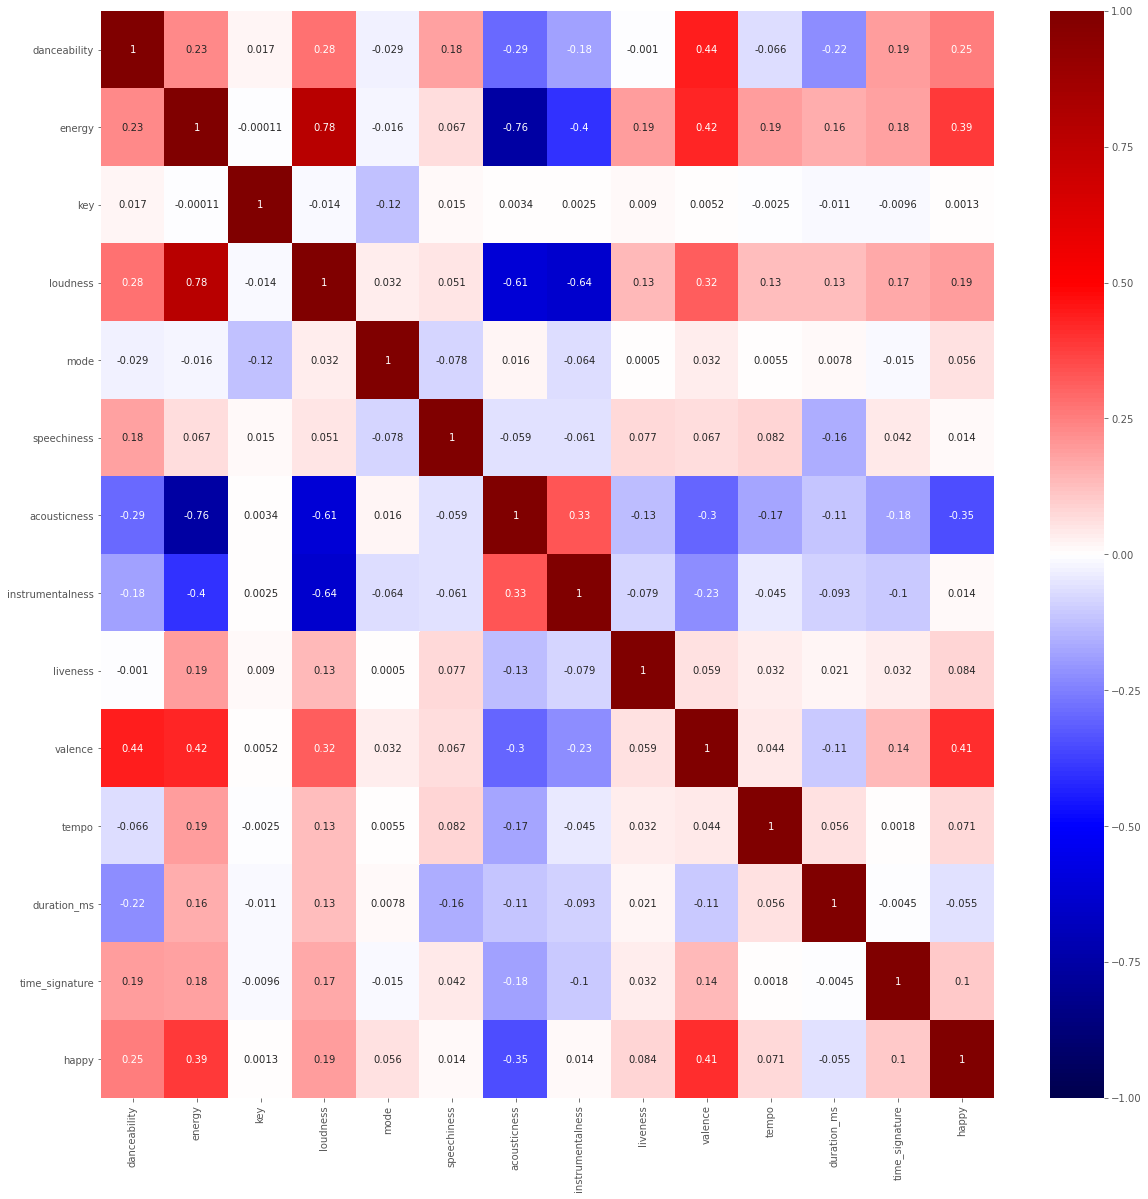

In [4]:

plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

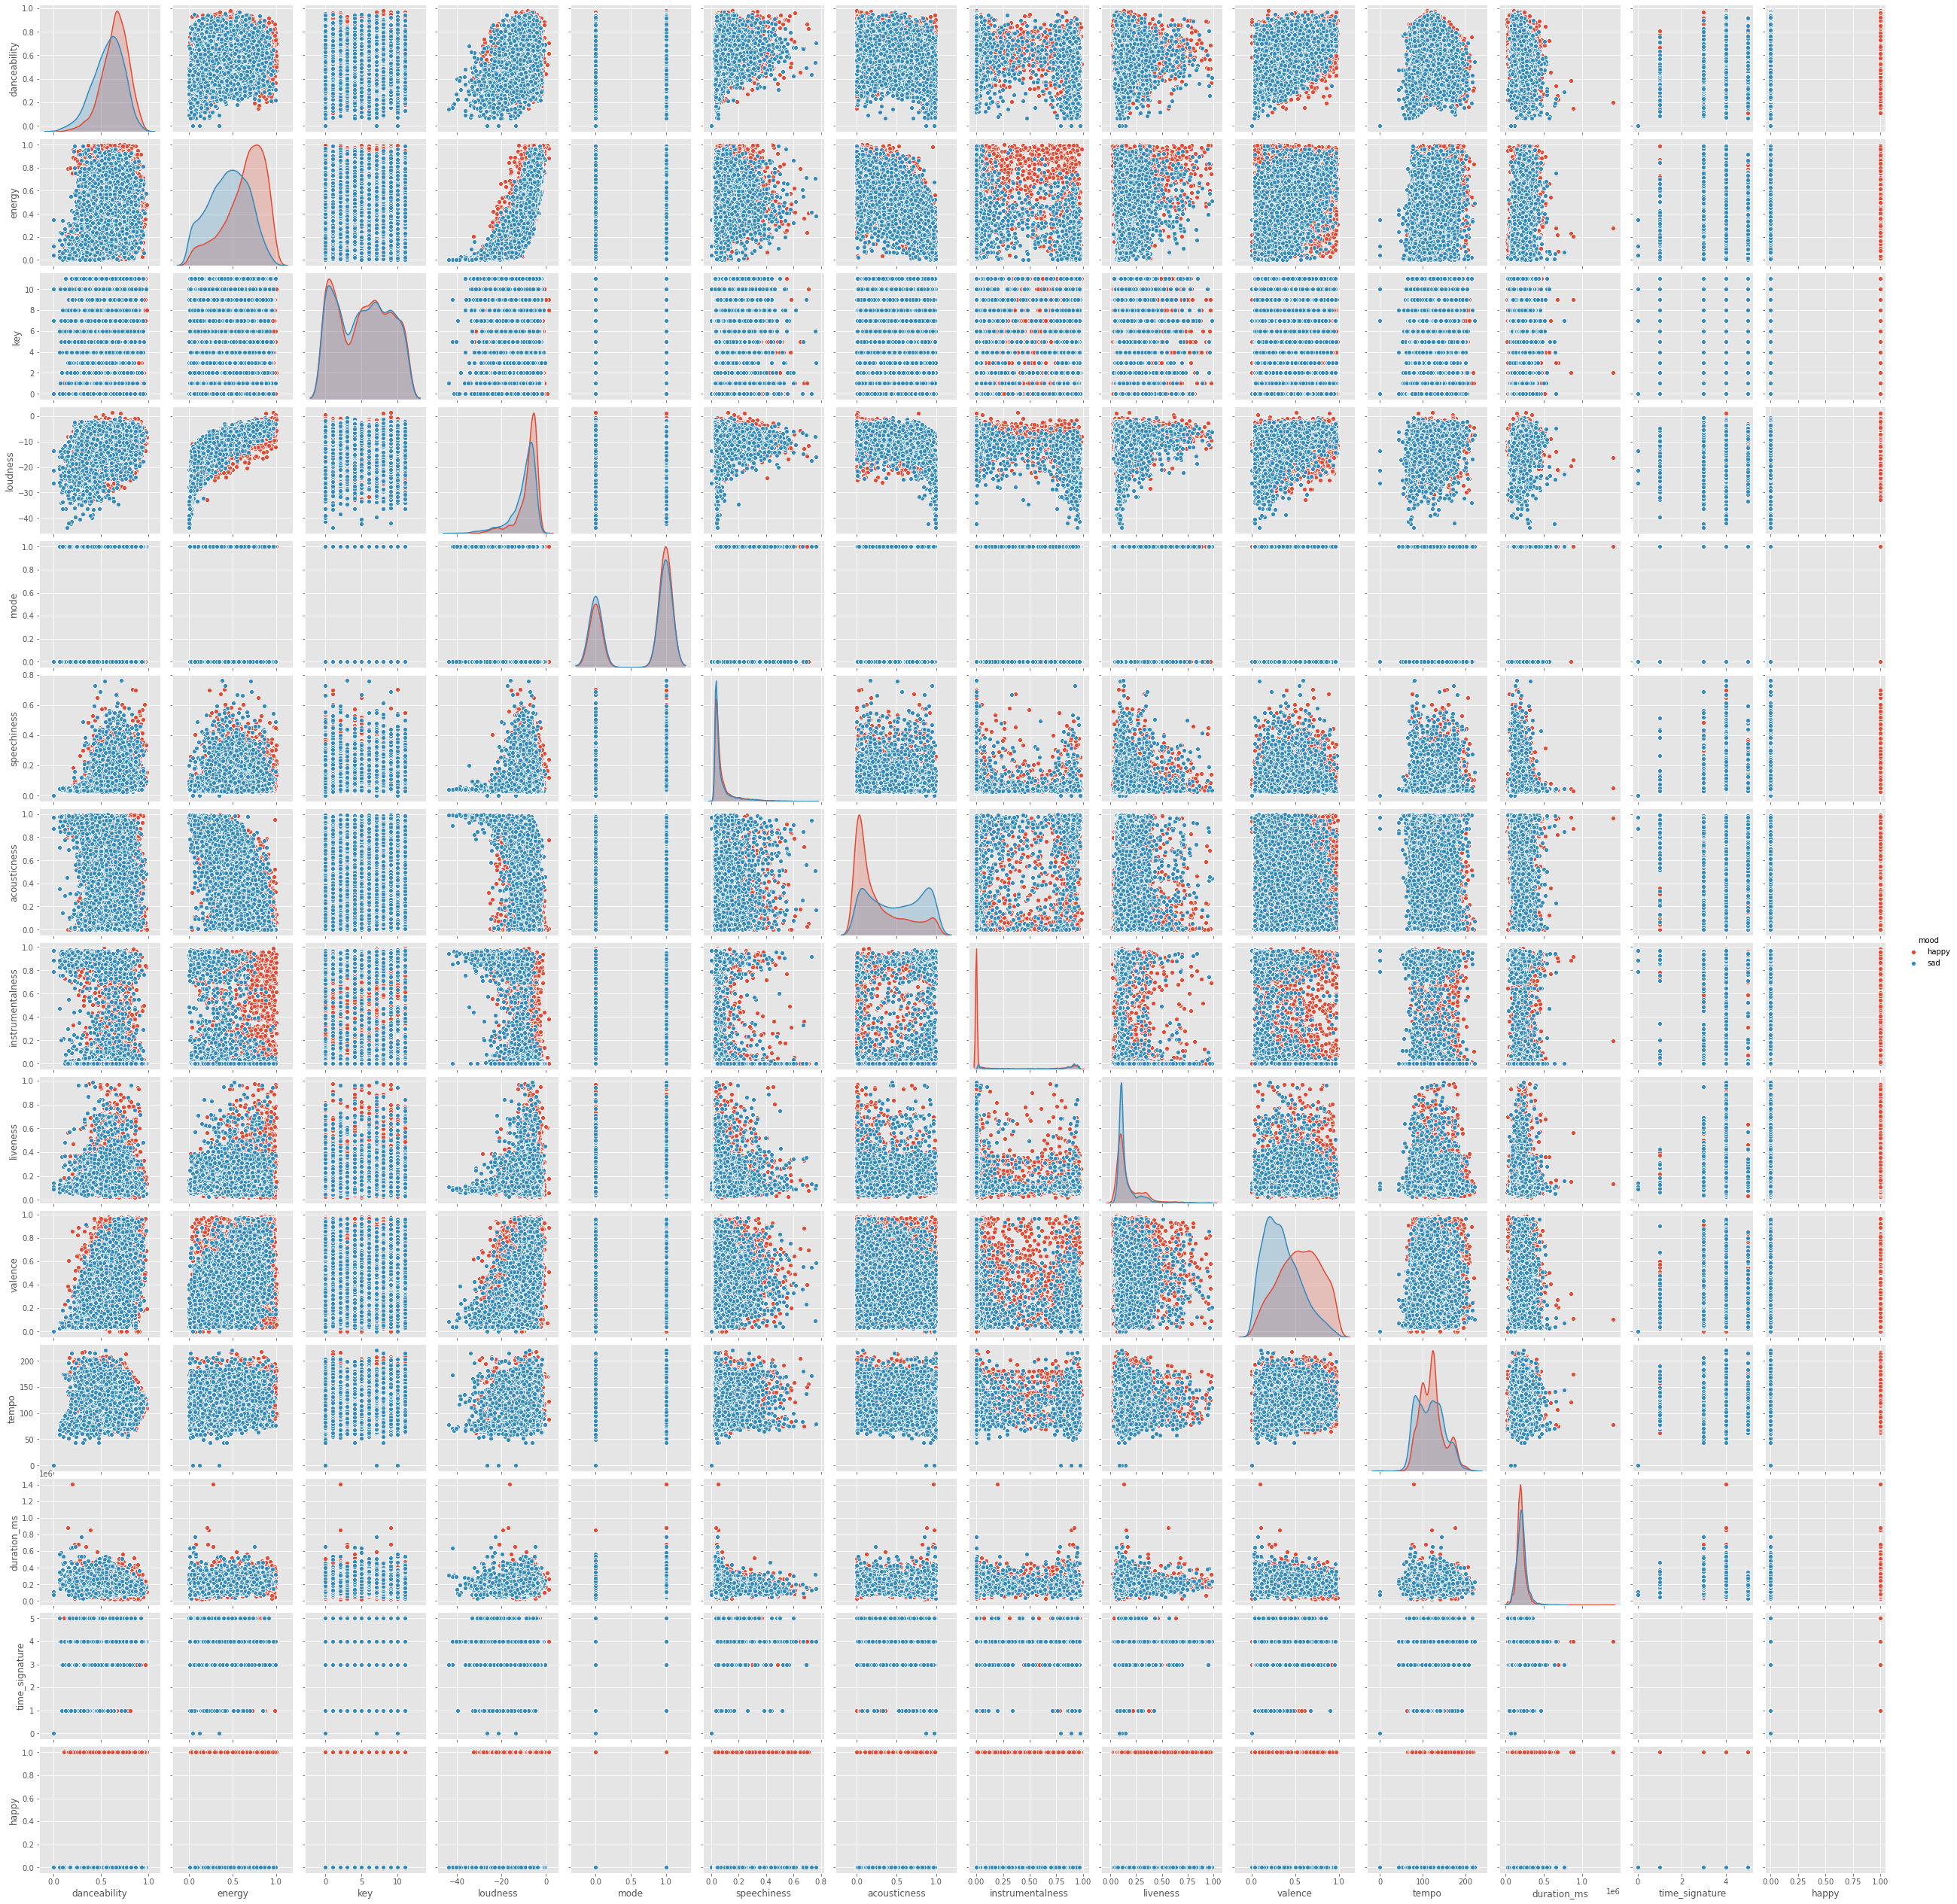

In [5]:
#Let's see what features are potentially useful. It looks like energy, acousticness, and valence are my best features that differentiate happy vs sad.

sns.pairplot(df, hue='mood');

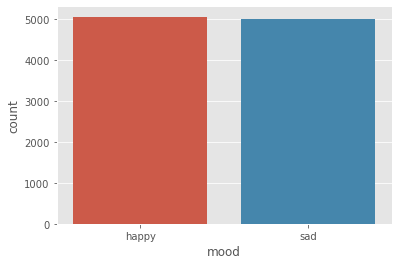

In [6]:
#Working with a balanced data set. No need for resampling. 

sns.countplot(x=df['mood'])

# Creating a Model Pipeline Function

In [7]:
def model_pipeline(X,y):
    '''
   Function to streamline model selection
    
    '''
    # 80:20 split holding out test set. Calling kfold because i have a small sample size
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2,random_state=42, stratify = y)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=43, stratify = y)
    kf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)

    classifiers = [KNeighborsClassifier(),LogisticRegression(),RandomForestClassifier(),XGBClassifier(n_jobs=-1,max_depth=4),AdaBoostClassifier(n_estimators = 100, random_state=0)]
    class_label = ['k-Nearest Neighbor','Logistic Regression','Random Forest','XGBoost','Adaboost']
    columns = ['Classifier','ROC AUC','Accuracy','Precision','Recall','F1-Score']

    clf_df = pd.DataFrame(index=[0],columns=columns)
    fig = plt.figure(figsize=(12,4))

    for clf in classifiers:
    
        # FIT CLASSIFIER
        clf.fit(X_train,y_train)

        # PREDICT ON TEST SET
        y_pred = clf.predict(X_test)

        # ACCURACY SCORE
        acc = accuracy_score(y_test, y_pred)
        
        # F1 SCORE
        f1 = f1_score(y_test, y_pred)

        # PROBABILITIES
        y_pred_prob = clf.predict_proba(X_test)[:,1]

        # ROC SCORES 
        fpr, tpr, thresholds = roc_curve(y_test,y_pred_prob)
        rocauc = roc_auc_score(y_test,y_pred_prob)

        # ROC CURVES
        ax1= plt.subplot(121)
        plt.plot([0,1], [0,1], color='navy', lw=1)
        plt.plot(fpr, tpr, lw=1, label=class_label[classifiers.index(clf)])
        plt.xlim([-.05, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC Curves')
        plt.legend(loc='best',fontsize=12)

        # PRECISION & RECALL 
        prscore = precision_score(y_test,clf.predict(X_test))
        recscore = recall_score(y_test,clf.predict(X_test))

        # ADD SCORES TO DF
        clf_df.loc[classifiers.index(clf)] = [class_label[classifiers.index(clf)],
                                              '{:.2%}'.format(rocauc),
                                              '{:.2%}'.format(acc),'{:.2%}'.format(prscore),
                                              '{:.2%}'.format(recscore),'{:.2%}'.format(f1)]

    plt.tight_layout()
    clf_df = clf_df.set_index('Classifier')
    print(clf_df)
    plt.show()


In [8]:
#Let me fit a model first with all of our features

X = df.loc[:,['danceability', 'energy', 'key', 
                      'loudness', 'mode', 'speechiness', 
                      'acousticness', 'instrumentalness', 'liveness', 
                      'valence','tempo']]

y = df['happy']

Performance Metrics:
Precision: Out of all predicted happy songs, how many are actually happy?
Recall: Out of all scrapped happy songs, how many did I predict to be happy?

Neither one is more important than the other. As a result,I'll be focusing on accuracy and F1 score with an equal 50/50 weight on both precision and recall as my scoring metrics. 

**Initial Model with All Variables**

                    ROC AUC Accuracy Precision  Recall F1-Score
Classifier                                                     
k-Nearest Neighbor   64.18%   60.95%    61.04%  61.52%   61.28%
Logistic Regression  80.11%   73.17%    72.24%  75.67%   73.91%
Random Forest        82.51%   76.15%    75.50%  77.74%   76.61%
XGBoost              82.77%   75.16%    74.73%  76.36%   75.54%
Adaboost             81.14%   74.17%    74.38%  74.09%   74.23%


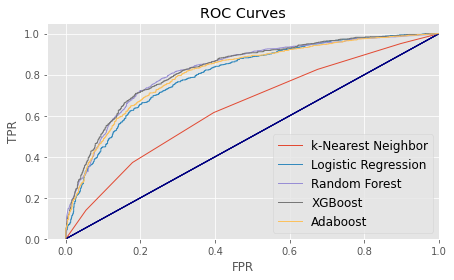

In [9]:
model_pipeline(X,y)

Looks like random forest will be my model as it outperforms all other models in Accuracy and F1 Score. I will try to simplify the model with different combinations of 3 of my most disticntive variables: valence, energy, and acousticness.

# Variable Selection


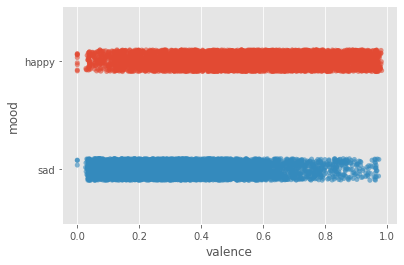

In [10]:
sns.stripplot(x='valence',y='mood', jitter=True,data=df,alpha=0.6);

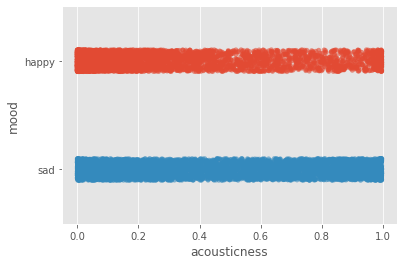

In [11]:
sns.stripplot(x='acousticness',y='mood', jitter=True,data=df,alpha=0.6);

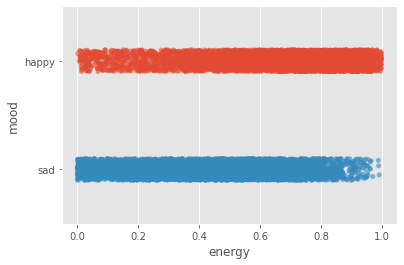

In [12]:
sns.stripplot(x='energy',y='mood', jitter=True,data=df,alpha=0.6);

In [13]:
v_X = df.loc[:,['valence']]

a_X = df.loc[:,['acousticness']]

e_X = df.loc[:,['energy']]

va_X = df.loc[:,['valence','acousticness']]

ae_X = df.loc[:,['acousticness','energy']]

ve_X = df.loc[:,['valence','energy']]

ae_X = df.loc[:,['acousticness','energy']]

vae_X = df.loc[:,['energy', 'acousticness', 'valence']]

                    ROC AUC Accuracy Precision  Recall F1-Score
Classifier                                                     
k-Nearest Neighbor   67.04%   63.34%    62.84%  66.07%   64.42%
Logistic Regression  73.57%   68.01%    67.83%  69.04%   68.43%
Random Forest        66.46%   62.34%    62.39%  63.01%   62.70%
XGBoost              72.11%   67.26%    66.67%  69.63%   68.12%
Adaboost             72.91%   67.36%    68.51%  64.79%   66.60%


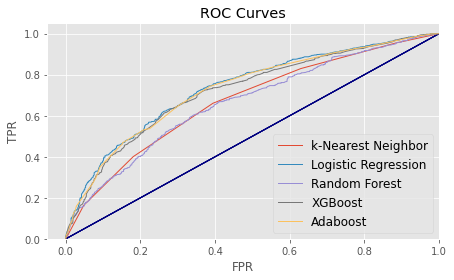

In [14]:
model_pipeline(v_X,y)

                    ROC AUC Accuracy Precision  Recall F1-Score
Classifier                                                     
k-Nearest Neighbor   65.19%   61.75%    61.71%  62.81%   62.25%
Logistic Regression  70.06%   63.93%    62.45%  70.72%   66.33%
Random Forest        63.84%   59.96%    60.78%  57.17%   58.92%
XGBoost              69.93%   64.38%    64.97%  63.11%   64.02%
Adaboost             70.23%   64.93%    64.00%  68.94%   66.38%


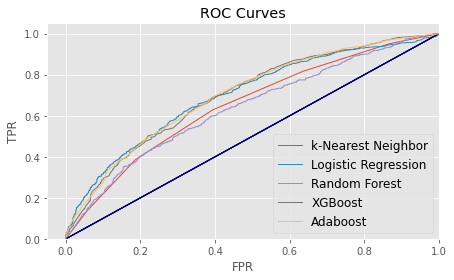

In [15]:
model_pipeline(a_X,y)

                    ROC AUC Accuracy Precision  Recall F1-Score
Classifier                                                     
k-Nearest Neighbor   66.76%   62.99%    62.79%  64.59%   63.68%
Logistic Regression  73.14%   66.52%    65.19%  71.51%   68.21%
Random Forest        67.38%   62.79%    62.45%  64.99%   63.69%
XGBoost              71.95%   66.32%    67.62%  63.20%   65.34%
Adaboost             72.60%   67.21%    69.74%  61.33%   65.26%


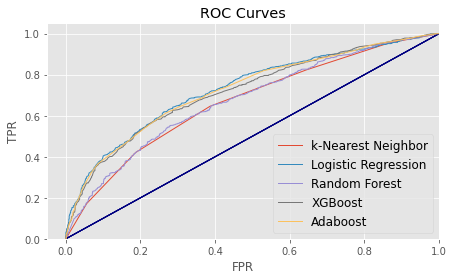

In [16]:
model_pipeline(e_X,y)

                    ROC AUC Accuracy Precision  Recall F1-Score
Classifier                                                     
k-Nearest Neighbor   74.06%   67.86%    67.67%  68.94%   68.30%
Logistic Regression  76.76%   69.20%    68.25%  72.30%   70.22%
Random Forest        73.68%   67.76%    67.30%  69.63%   68.45%
XGBoost              78.08%   70.44%    70.16%  71.61%   70.88%
Adaboost             78.22%   71.34%    71.44%  71.51%   71.48%


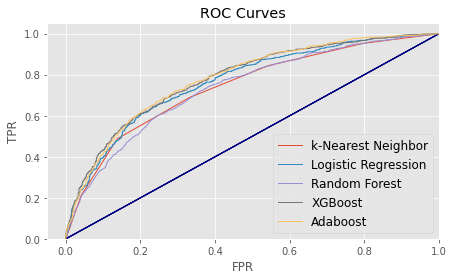

In [17]:
model_pipeline(va_X,y)

                    ROC AUC Accuracy Precision  Recall F1-Score
Classifier                                                     
k-Nearest Neighbor   73.78%   68.36%    67.84%  70.33%   69.06%
Logistic Regression  77.50%   70.99%    69.50%  75.27%   72.27%
Random Forest        73.20%   66.17%    66.02%  67.26%   66.63%
XGBoost              78.01%   71.19%    70.27%  73.89%   72.03%
Adaboost             78.36%   71.78%    72.17%  71.32%   71.74%


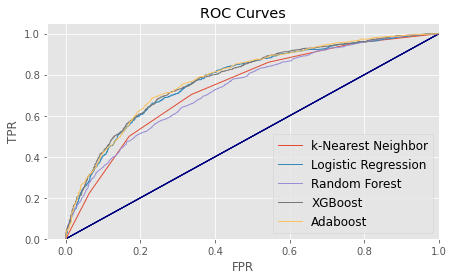

In [18]:
model_pipeline(ve_X,y)

                    ROC AUC Accuracy Precision  Recall F1-Score
Classifier                                                     
k-Nearest Neighbor   68.43%   63.44%    64.04%  62.02%   63.02%
Logistic Regression  73.83%   66.77%    65.05%  73.10%   68.84%
Random Forest        69.13%   62.64%    62.94%  62.31%   62.62%
XGBoost              73.18%   66.27%    67.97%  62.12%   64.91%
Adaboost             73.87%   67.21%    69.06%  62.91%   65.84%


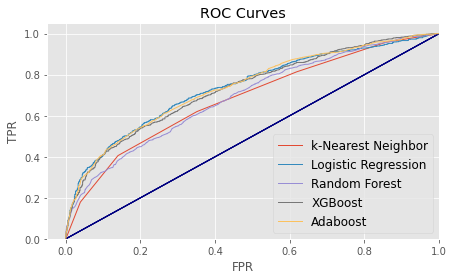

In [19]:
model_pipeline(ae_X,y)

                    ROC AUC Accuracy Precision  Recall F1-Score
Classifier                                                     
k-Nearest Neighbor   75.16%   70.09%    70.59%  69.34%   69.96%
Logistic Regression  77.80%   70.84%    69.41%  74.98%   72.09%
Random Forest        77.67%   70.64%    70.51%  71.41%   70.96%
XGBoost              79.56%   72.13%    71.72%  73.49%   72.59%
Adaboost             79.66%   73.27%    73.91%  72.30%   73.10%


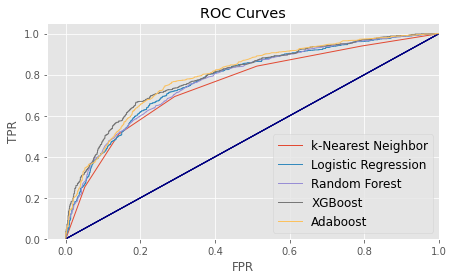

In [20]:
model_pipeline(vae_X,y)

Looks like my model performed significantly better (higher accuracy and F1-Scores) with all features. I'll decide to keep all the features, as I only have 11 features. Now that I've decided to use a Random Forest model and keep all my features, it's time to hyptertune parameters with GridSearch. 

# Hypertuning Final Model Parameters (Random Forest)

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': np.arange(10,200,10),
              'min_samples_leaf': np.arange(1,100,10),
              'max_features': ['auto', 'sqrt', 'log2']}

rf = RandomForestClassifier()
rf_cv = GridSearchCV(rf, param_grid, cv=5)
rf_cv.fit(X, y)

print(rf_cv.best_params_)
print(rf_cv.best_score_)

ne=rf_cv.best_params_['n_estimators']
msl=rf_cv.best_params_['min_samples_leaf']
mf=rf_cv.best_params_['max_features']

{'max_features': 'log2', 'min_samples_leaf': 11, 'n_estimators': 50}
0.7492460537322513


Fit final model with optimal parameters over entire dataset

In [11]:
# Create the classifier
final_model = RandomForestClassifier(n_estimators=50,
                            min_samples_leaf=11,
                            max_features='log2')

# Fit the classifier to the training data
final_model.fit(X, y)

# Predict on the test set
y_pred_final_model = final_model.predict(X)

# PREDICTION PROBABILITIES
y_pred_prob_final_model = final_model.predict_proba(X)[:,1]

In [16]:
print('ROC AUC Score:','{:.2%}'.format(roc_auc_score(y, y_pred_prob_final_model)))
print('Test Accuracy:', '{:.2%}'.format(accuracy_score(y, y_pred_final_model)))
print('Precision:','{:.2%}'.format(precision_score(y, y_pred_final_model)))
print('Recall:', '{:.2%}'.format(recall_score(y, y_pred_final_model)))
print('F1 Score:', '{:.2%}'.format(f1_score(y, y_pred_final_model)))

#print('Recall:', recall_score(y_test,rf.predict(X_test))

print('\n Clasification Report:\n', classification_report(y, y_pred_final_model))

ROC AUC Score: 93.24%
Test Accuracy: 84.20%
Precision: 83.97%
Recall: 84.71%
F1 Score: 84.34%

 Clasification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      5008
           1       0.84      0.85      0.84      5054

    accuracy                           0.84     10062
   macro avg       0.84      0.84      0.84     10062
weighted avg       0.84      0.84      0.84     10062



Pretty significant increase in both Accuracy and F1-score when finished with hypertuning and fiting over the entire dataset. Not bad!

# Feature Importance and Confusion Matrix

In [13]:
names = df.columns
print(sorted(zip(map(lambda x: round(x, 4), final_model.feature_importances_), names), 
             reverse=True))

[(0.2464, 'valence'), (0.2049, 'energy'), (0.1447, 'acousticness'), (0.0847, 'danceability'), (0.0839, 'tempo'), (0.0655, 'instrumentalness'), (0.0572, 'loudness'), (0.0434, 'speechiness'), (0.0404, 'liveness'), (0.0182, 'key'), (0.0108, 'mode')]


Like I guessed, valence, energy, and acousticness would be most important in deciding whether a not a song will be happy or sad. 

In [14]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X)[:, 1] >= threshold)
    mood_confusion = confusion_matrix(y, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(mood_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['happy', 'sad'],
           yticklabels=['happy', 'sad']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [15]:
# Let's see how our confusion matrix changes with changes to the cutoff! 

from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(final_model, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…